In [1]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import folium
from osmnx._errors import InsufficientResponseError

In [2]:
bkk_boundary = ox.geocode_to_gdf('Bangkok, Thailand')

In [3]:
# bkk_boundary = ox.projection.project_gdf(bkk_boundary, to_crs='epsg:32647')

<Axes: >

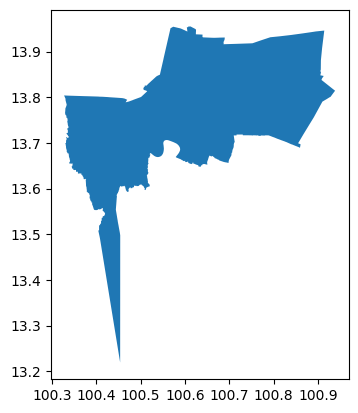

In [4]:
bkk_boundary.plot()

# Project data to epsg 32647

## Bike sharing location

In [5]:
bike_sharing_loc = gpd.read_file('data/punpunbike/punpunbike.shp')

In [6]:
bike_sharing_loc = bike_sharing_loc.set_crs(epsg=4326, allow_override=True)
bike_sharing_loc = bike_sharing_loc.to_crs(epsg=32647)

<Axes: >

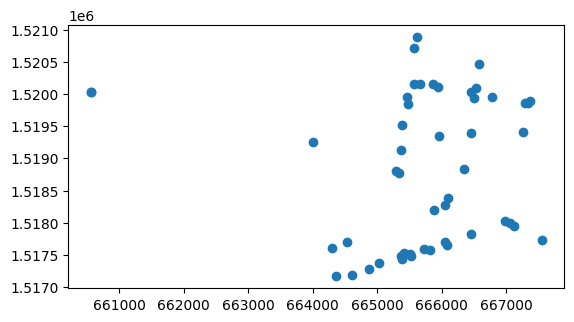

In [7]:
bike_sharing_loc.plot()

## bike route

In [8]:
bike_route = gpd.read_file('data/bike_way/bike_way.shp')

In [9]:
bike_route = bike_route.to_crs(epsg=32647)

<Axes: >

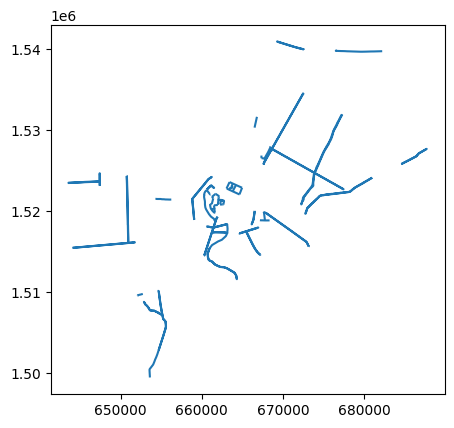

In [10]:
bike_route.plot()

### Create buffer from bike route (~500 m)

In [11]:
bike_route_buffer_df = bike_route.copy()
bike_route_buffer_df['geometry'] = bike_route_buffer_df.geometry.buffer(400)

<Axes: >

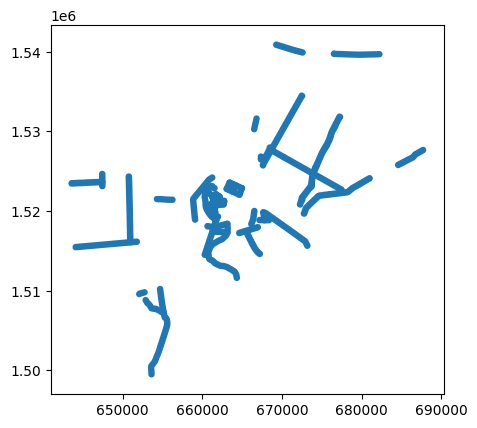

In [12]:
bike_route_buffer_df.plot()

Interested tags
- amenity = cafe, ice_cream, restaurant, arts_centre, fountain
- building = religious, temple
- historic = *
- leisure = park, nature_reserve
- shop = bakery, coffee, food, ice_cream, pastry, department_store
- tourism = attraction, information, viewpoint, zoo

In [13]:
# poi_tags = {'amenity': ['restaurant', 'cafe', 'ice_cream', 'arts_centre', 'fountain'],
#             'building': ['religious', 'temple'],
#             'historic': '*',
#             'leisure': ['park', 'nature_reserve'],
#             'shop': ['bakery', 'coffee', 'food', 'ice_cream', 'pastry', 'department_store'],
#             'tourism': ['attraction', 'information', 'viewpoint', 'zoo']
#             }

poi_tags = {'building': ['religious', 'temple'],
            'historic': True,
            'leisure': ['park', 'nature_reserve'],
            'shop': ['bakery', 'coffee', 'food', 'ice_cream', 'pastry', 'department_store'],
            'tourism': ['attraction', 'viewpoint', 'zoo']
            }

In [14]:
bike_route_buffer_df = bike_route_buffer_df.to_crs(epsg=4326)

In [15]:
for i in range(len(bike_route_buffer_df)):
    try:
        poi_result = ox.features.features_from_polygon(bike_route_buffer_df['geometry'].loc[i], poi_tags)
        if poi_result.empty:
            print(f"No POIs found in buffer {i}")
        
        if i==0:
            poi_df = poi_result.copy()
        else:
            poi_df = pd.concat([poi_df, poi_result], ignore_index=True)
    except InsufficientResponseError:
        print(f"No matching features in polygon {i} - skipping")
        continue
    except Exception as e:
        print(f"Other error in polygon {i}: {e}")
        continue

No matching features in polygon 31 - skipping
No matching features in polygon 32 - skipping


In [16]:
# # Calculate center point for map
# center_lat = bike_route_buffer_df.geometry.centroid.y.mean()
# center_lon = bike_route_buffer_df.geometry.centroid.x.mean()

# Create folium map
# m = folium.Map(location=[center_lat, center_lon], zoom_start=13, tiles='OpenStreetMap')
m = folium.Map(zoom_start=13, tiles='OpenStreetMap')

# Add buffer zones
folium.GeoJson(
    bike_route_buffer_df.to_json(),
    style_function=lambda x: {'fillColor': 'blue', 'color': 'blue', 'weight': 2, 'fillOpacity': 0.3}
).add_to(m)

# Add POIs
folium.GeoJson(
    poi_df[~poi_df['name'].isna()].to_json(),
    popup=folium.GeoJsonPopup(fields=['name']),
    marker=folium.CircleMarker(radius=5, color='red', fillColor='red', fillOpacity=0.8)
).add_to(m)

# Display map
m